In [2]:
import pandas as pd
import re

def evaluate_output(llm_output):
    """Evaluates LLM output based on template adherence and assigns a weighted float score."""

    # Define the expected variables and their types
    EXPECTED_VARIABLES_TYPES = {
        "damage": "float",
        "swingSpeed": "float",
        "hasDamageOverTime": "bool",
        "dotDamage": "float",
        "dotDuration": "float",
        "fireBonusDamage": "float",
        "iceBonusDamage": "float",
        "lightningBonusDamage": "float",
        "critChance": "float",
        "critMultiplier": "float",
        "swingArc": "float",
        "colliderSize": "Vector2"
    }

    # 1. Completeness: Are all expected variables declared in *any* way in the output? 
    # (Doesn't validate types here, just presence of the variable name.)
    missing_variables = []
    for var_name in EXPECTED_VARIABLES_TYPES.keys():
        if var_name not in llm_output:
            missing_variables.append(var_name)

    completeness_score = 1.0 - (len(missing_variables) / len(EXPECTED_VARIABLES_TYPES))

    # 2. Correctness: Is each variable declared correctly with type and value format?
    correctness_count = 0
    incorrect_variables = []

    # Type patterns
    float_pattern = r"= [-+]?[0-9]*\.?[0-9]+f;"
    bool_pattern = r"= (true|false);"
    vector2_pattern = r"= new Vector2\(\s*[-+]?[0-9]*\.?[0-9]+f?,\s*[-+]?[0-9]*\.?[0-9]+f?\);"

    for var_name, var_type in EXPECTED_VARIABLES_TYPES.items():
        if var_type == "float":
            # Look for public float <var_name> = ...f;
            pattern = re.compile(
                rf'public\s+float\s+{re.escape(var_name)}\s*{float_pattern}',
                re.IGNORECASE
            )
        elif var_type == "bool":
            pattern = re.compile(
                rf'public\s+bool\s+{re.escape(var_name)}\s*{bool_pattern}',
                re.IGNORECASE
            )
        elif var_type == "Vector2":
            pattern = re.compile(
                rf'public\s+Vector2\s+{re.escape(var_name)}\s*{vector2_pattern}',
                re.IGNORECASE
            )
        else:
            continue  # Unknown type, skip

        match = pattern.search(llm_output)

        if match:
            correctness_count += 1
        else:
            incorrect_variables.append(var_name)

    correctness_score = correctness_count / len(EXPECTED_VARIABLES_TYPES)

    # calculates the weighted score 
    final_score = ( 
        (0.8 * completeness_score) + 
        (0.2 * correctness_score) 
    )

    return round(final_score, 2)

def calculate_scores(df):
    """
    Applies evaluate_output() to each model output, then aggregates scores by model, size, and run.

    Parameters:
    - df (DataFrame): The compiled DataFrame with model outputs.

    Returns:
    - detailed_df (DataFrame): Includes individual scores per prompt.
    - summary_df (DataFrame): Aggregated scores per model, size, and run + prompt counts, deviation, best/worst scores.
    """

    # Apply evaluation to each LLM output (if not already done)
    df["Score"] = df["Output"].apply(evaluate_output)

    # Compute aggregated metrics
    summary_df = df.groupby(["Model", "Size", "Run"]).agg(
        Average_Score=("Score", "mean"),
        Score_StdDev=("Score", "std"),     # Standard deviation of scores
        Best_Score=("Score", "max"),       # Best (highest) score
        Worst_Score=("Score", "min"),      # Worst (lowest) score
        Prompt_Count=("Score", "count")    # Number of prompts
    ).reset_index()

    return df, summary_df





In [3]:
df_combined = pd.read_csv('Combined_results.csv')
df_combined["Output"] = df_combined["Output"].fillna('null') #fill NA values to "null" so they are strings 

df_detailed, df_summary = calculate_scores(df_combined)

# Display both the detailed scores and summary scores
from IPython.display import display
display(df_detailed)  # Shows individual scores per prompt
display(df_summary)  # Shows average scores per model, size, and run




,Run,Model,Size,Prompt,Output,Score
0,1,Qwen,14Bs,A big heavy sword.,public class BigHeavySword : MonoBehaviour {\n...,0.00
1,1,Qwen,7b,A big heavy sword.,```csharp\n\nusing UnityEngine;\n\npublic clas...,0.07
2,2,Qwen,14Bs,A big heavy sword.,```csharp\nusing UnityEngine;\n\n[CreateAssetM...,0.07
3,2,Qwen,7b,A big heavy sword.,Sure! Here's your requested script implementin...,0.07
4,3,Qwen,14Bs,A big heavy sword.,Assistant: using UnityEngine;\n\n[CreateAssetM...,0.00
...,...,...,...,...,...,...
598,3,StarCoder2,7b,"A thin, fast sword.",tems { get; set;}\n string description ...,0.00
599,4,StarCoder2,15B,"A thin, fast sword.",﻿using System;\nusing System.Collections;\nusi...,0.00
600,4,StarCoder2,7b,"A thin, fast sword.",﻿using System;\nusing System.Collections;\nusi...,0.00
601,5,StarCoder2,15B,"A thin, fast sword.",﻿namespace JamieKnight.ScriptableObjects.Examp...,0.00


,Model,Size,Run,Average_Score,Score_StdDev,Best_Score,Worst_Score,Prompt_Count
0,Lamma,13B,1,0.51300,0.308717,0.97,0.00,20
1,Lamma,13B,2,0.61800,0.461583,1.00,0.00,20
2,Lamma,13B,3,0.34600,0.484066,1.00,0.00,20
3,Lamma,13B,4,0.37650,0.443743,1.00,0.00,20
4,Lamma,13B,5,0.29600,0.464196,1.00,0.00,20
5,Lamma,7B,1,0.23600,0.235649,0.73,0.00,20
6,Lamma,7B,2,0.09150,0.187091,0.80,0.00,20
7,Lamma,7B,3,0.09550,0.198692,0.67,0.00,20
8,Lamma,7B,4,0.18400,0.329647,1.00,0.00,20
9,Mixtral,UnknownSize,1,0.13000,NaN,0.13,0.13,1


In [4]:
import matplotlib.pyplot as plt

def plot_score_distributions(df_detailed):
    models = df_detailed['Model'].replace({'lamma 13B': 'Llama 13B', 'lamma 7B': 'Llama 7B'}).unique()

    # Identify models with highest count of score 1 and highest average
    df_detailed['Model'] = df_detailed['Model'].replace({'lamma 13B': 'Llama 13B', 'lamma 7B': 'Llama 7B'})
    score1_counts = df_detailed[df_detailed['Score'] == 1].groupby('Model').size()
    highest_score1_model = score1_counts.idxmax() if not score1_counts.empty else None

    avg_scores = df_detailed.groupby('Model')['Score'].mean()
    highest_avg_model = avg_scores.idxmax()

    for model in models:
        model_df = df_detailed[df_detailed['Model'] == model]
        runs = sorted(model_df['Run'].unique())

        plt.figure(figsize=(10, 6))

        for run in runs:
            run_scores = model_df[model_df['Run'] == run]['Score']

            # Determine if this should be highlighted
            if model == highest_score1_model or model == highest_avg_model:
                color = None  # default color
                edgecolor = 'black'
                alpha = 1.0
                hatch = '//' if model == highest_avg_model else ''
            else:
                color = 'grey'
                edgecolor = 'lightgrey'
                alpha = 0.3
                hatch = ''

            plt.hist(run_scores, bins=20, alpha=alpha, label=f'Run {run}',
                     color=color, edgecolor=edgecolor, linewidth=1.2, hatch=hatch)

        plt.legend(title='Run')
        plt.title(f'Score Distribution for Model: {model}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(f'score_distribution_{model}.png', format='png', dpi=600)
        plt.show()


def plot_run_distributions(df_detailed):
    df_detailed['Model'] = df_detailed['Model'].replace({'lamma 13B': 'Llama 13B', 'lamma 7B': 'Llama 7B'})
    df_detailed['Model_Size'] = df_detailed['Model'] + ' ' + df_detailed['Size'].astype(str)

    # Identify model/size with highest count of score 1 and highest average
    score1_counts = df_detailed[df_detailed['Score'] == 1].groupby('Model_Size').size()
    highest_score1_modelsize = score1_counts.idxmax() if not score1_counts.empty else None

    avg_scores = df_detailed.groupby('Model_Size')['Score'].mean()
    highest_avg_modelsize = avg_scores.idxmax()

    runs = sorted(df_detailed['Run'].unique())

    for run in runs:
        run_df = df_detailed[df_detailed['Run'] == run]
        model_size_combos = run_df[['Model', 'Size']].drop_duplicates()

        plt.figure(figsize=(10, 6))

        for _, row in model_size_combos.iterrows():
            model = row['Model']
            size = row['Size']
            model_size = f'{model} {size}'

            scores = run_df[
                (run_df['Model'] == model) &
                (run_df['Size'] == size)
            ]['Score']

            if model_size == highest_score1_modelsize or model_size == highest_avg_modelsize:
                color = None  # default color
                edgecolor = 'black'
                alpha = 1.0
                hatch = '//' if model_size == highest_avg_modelsize else ''
            else:
                color = 'grey'
                edgecolor = 'lightgrey'
                alpha = 0.3
                hatch = ''

            plt.hist(scores, bins=20, alpha=alpha, label=model_size,
                     color=color, edgecolor=edgecolor, linewidth=1.2, hatch=hatch)

        plt.legend(title='Model/Size')
        plt.title(f'Score Distribution for Run: {run}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(f'score_distribution_run_{run}.png', format='png', dpi=600)
        plt.show()


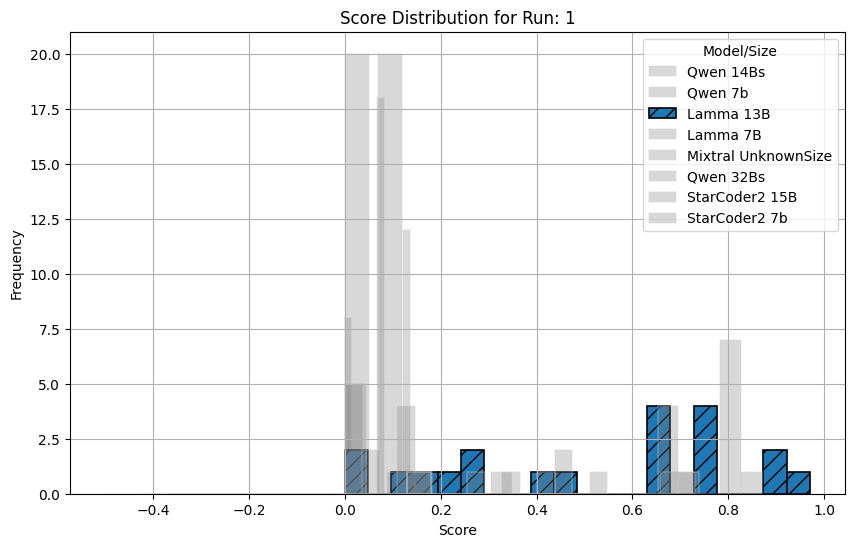

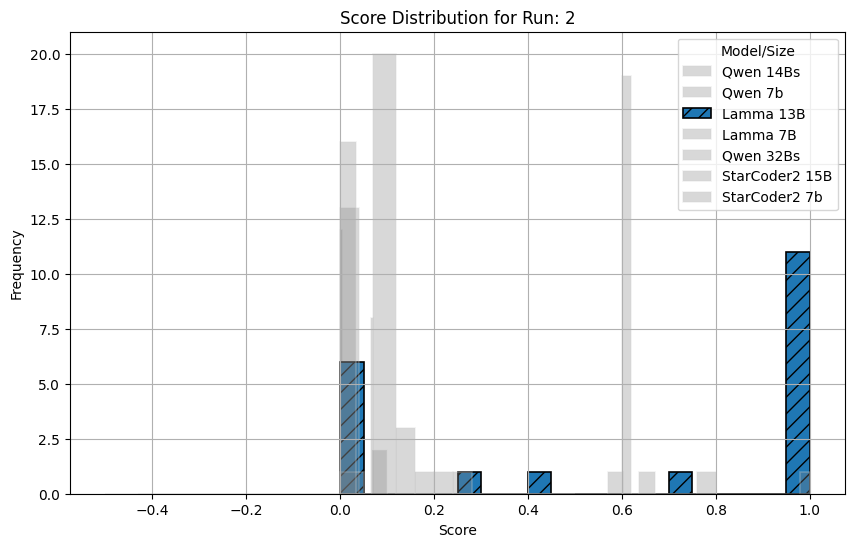

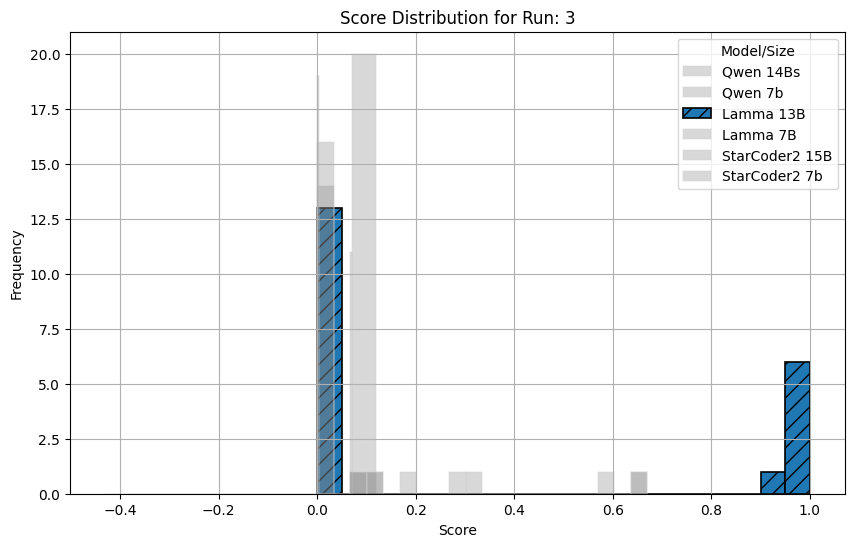

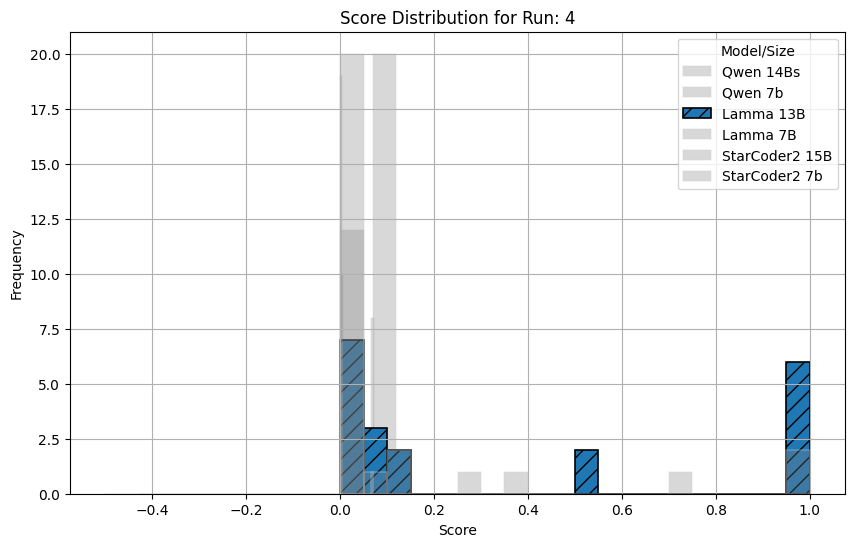

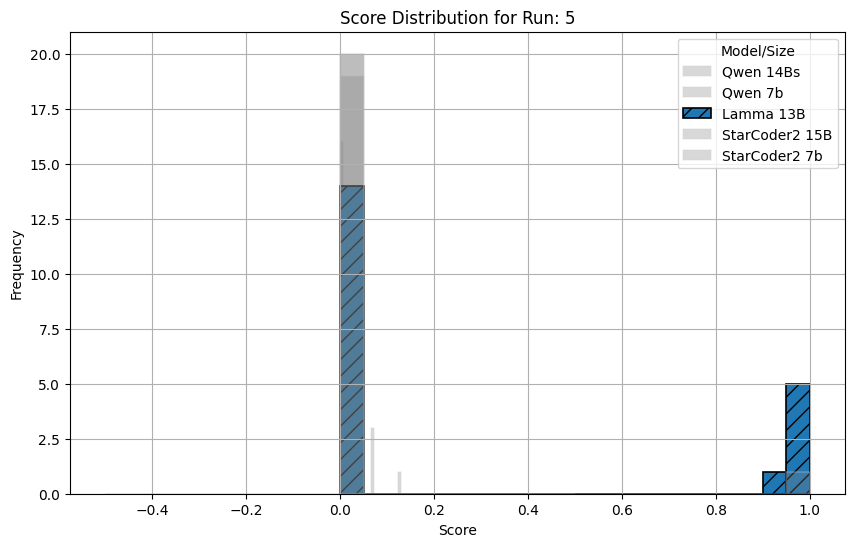

In [5]:
# plot_score_distributions(df_detailed)
plot_run_distributions(df_detailed)


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_run_distributions(df_detailed, use_kde=False):
    # Standardize the model names
    df_detailed['Model'] = df_detailed['Model'].replace({
        'lamma 13B': 'Llama 13B',
        'lamma 7B': 'Llama 7B'
    })

    # Fully remove excluded models
    excluded_models = ['Qwen 32Bs', 'Mixtral']
    df_detailed = df_detailed[~df_detailed['Model'].isin(excluded_models)]

    # Create Model_Size column
    df_detailed['Model_Size'] = df_detailed['Model'] + ' ' + df_detailed['Size'].astype(str)

    runs = sorted(df_detailed['Run'].unique())

    for run in runs:
        run_df = df_detailed[df_detailed['Run'] == run]

        model_size_combos = run_df[['Model', 'Size']].drop_duplicates()

        # Determine highest frequency of score 1
        score1_counts = run_df[run_df['Score'] == 1].groupby('Model_Size').size()
        highest_score1_modelsize = score1_counts.idxmax() if not score1_counts.empty else None

        plt.figure(figsize=(10, 6))

        for _, row in model_size_combos.iterrows():
            model = row['Model']
            size = row['Size']
            model_size = f'{model} {size}'

            scores = run_df[
                (run_df['Model'] == model) &
                (run_df['Size'] == size)
            ]['Score']

            if model_size == highest_score1_modelsize:
                # Colored bar + thick black edge
                plt.hist(scores, bins=20, alpha=0.8, label=model_size,
                         edgecolor='black', linewidth=2.0)
            else:
                # Normal colored bars, no edge
                plt.hist(scores, bins=20, alpha=0.5, label=model_size,
                         edgecolor=None)

        # Filter legend entries
        handles, labels = plt.gca().get_legend_handles_labels()
        filtered_handles_labels = [
            (h, l) for h, l in zip(handles, labels)
            if 'Qwen 32Bs' not in l and 'Mixtral' not in l
        ]
        handles, labels = zip(*filtered_handles_labels)

        plt.legend(handles, labels, title='Model/Size')
        plt.title(f'Score Distribution for Run: {run}')
        plt.xlabel('Score')
        plt.ylabel('Density' if use_kde else 'Frequency')
        plt.grid(True)
        plt.savefig(f'score_distribution_run_{run}.png', format='png', dpi=600)
        plt.show()


C:\Users\pbvan\AppData\Local\Temp\ipykernel_15032\968213158.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detailed['Model_Size'] = df_detailed['Model'] + ' ' + df_detailed['Size'].astype(str)


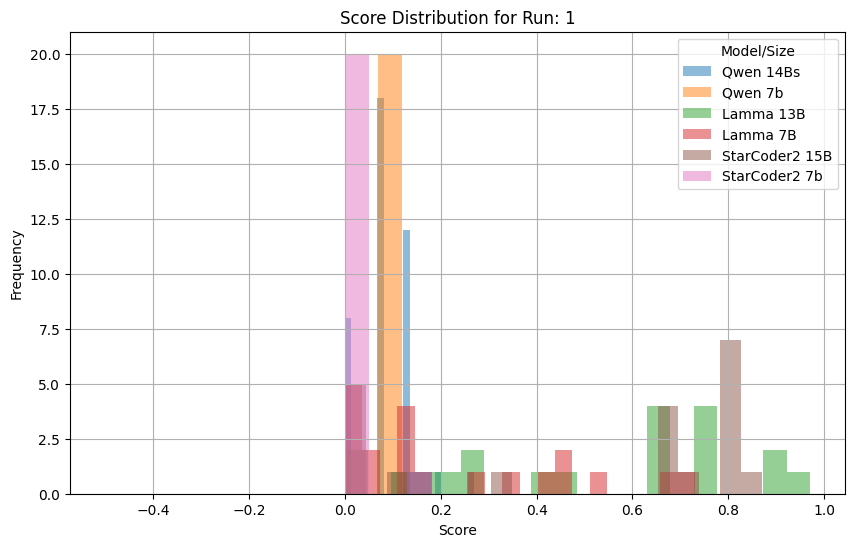

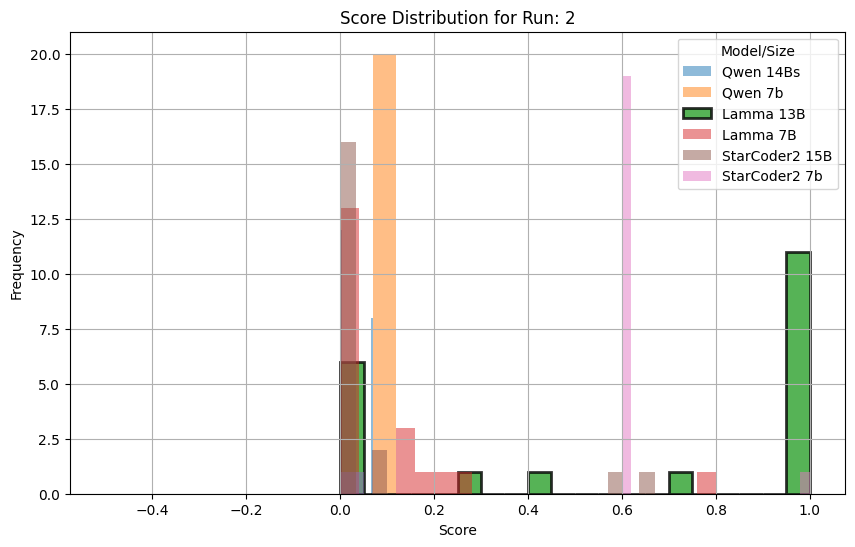

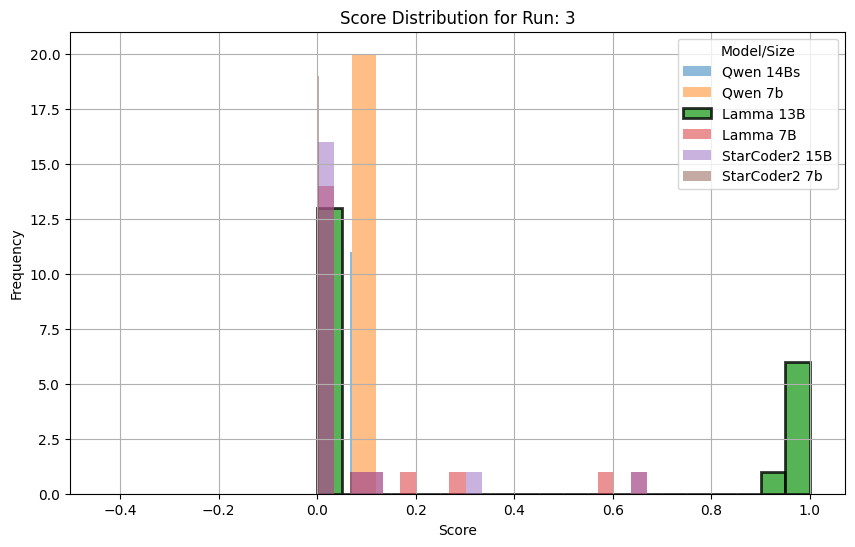

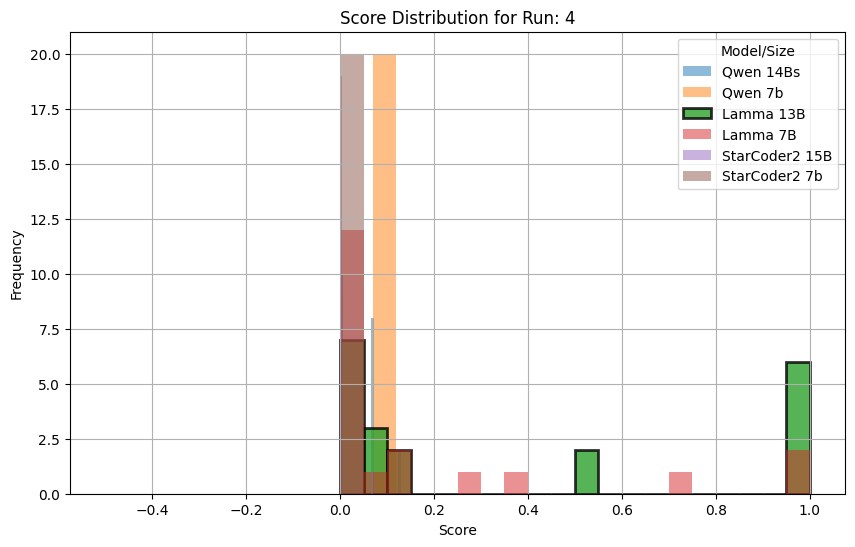

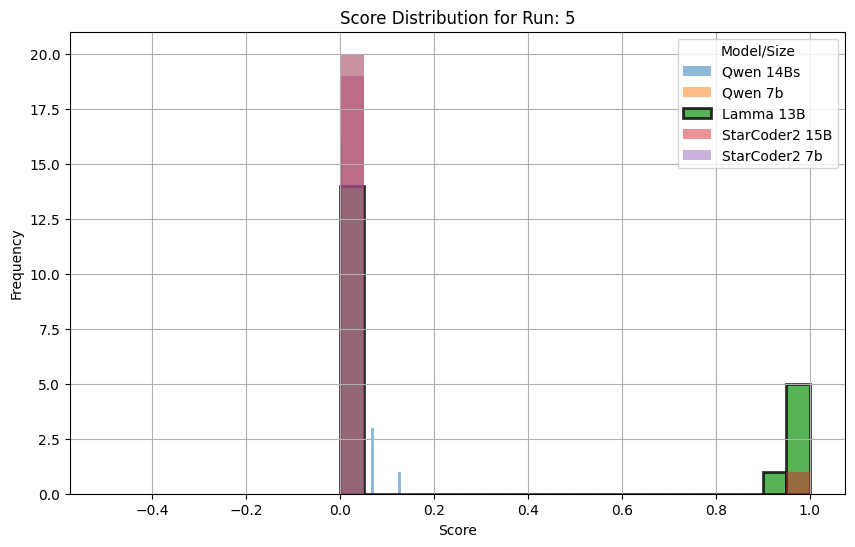

In [30]:
# For histograms (default)
plot_run_distributions(df_detailed)

# For KDE line plots
# plot_run_distributions(df_detailed, use_kde=True)


In [10]:
df_detailed.to_csv('Results_detailed_More_alt_Metric.csv', index=False)
df_summary.to_csv('Results_summary_More_alt_Metric.csv', index=False)

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_llama_model_distribution_highlight_13B(df_detailed, run=None, use_kde=False):
    # Standardize naming
    df_detailed['Model'] = df_detailed['Model'].str.strip().str.lower()
    df_detailed['Size'] = df_detailed['Size'].astype(str).str.strip()

    # Filter for Lamma/Llama model (all sizes)
    llama_df = df_detailed[df_detailed['Model'] == 'lamma']

    if run is not None:
        llama_df = llama_df[llama_df['Run'] == run]

    # Identify 13B entries
    llama_13b_df = llama_df[llama_df['Size'].str.lower() == '13b']

    if llama_df.empty:
        print("No data found for the Llama model!")
        return

    plt.figure(figsize=(10, 6))

    # Plot all Llama data (faded grey)
    plt.hist(llama_df['Score'], bins=20, alpha=0.3, color='grey', label='Llama (all sizes)', edgecolor=None)

    if not llama_13b_df.empty:
        # Highlight 13B size data
        plt.hist(llama_13b_df['Score'], bins=20, alpha=0.7, color='green', edgecolor='black', linewidth=1.5, label='Llama 13B')

    plt.title(f'Score Distribution for Llama Model{" (Run " + str(run) + ")" if run is not None else ""}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# plot_llama_model_distribution_highlight_13B(df_detailed)
# plot_llama_model_distribution_highlight_13B(df_detailed, run=2)


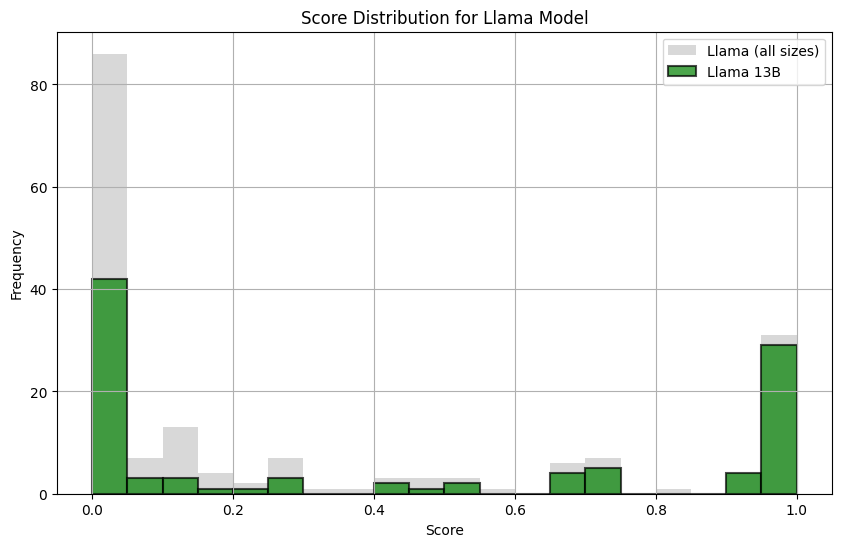

In [51]:
plot_llama_model_distribution_highlight_13B(df_detailed)

In [9]:
#Inspection function to randomly draw top and buttom prompts
import random

def get_random_top_bottom_prompts(df_detailed, top_x=5, bottom_x=5, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)

    # Sort dataframe by score
    df_sorted = df_detailed.sort_values(by="Score", ascending=False)

    # Select top and bottom prompts
    top_prompts_df = df_sorted.head(top_x * 2)  # Grab more than needed for randomness
    bottom_prompts_df = df_sorted.tail(bottom_x * 2)

    # Randomly sample from top and bottom selections
    top_prompts = top_prompts_df.sample(n=min(top_x, len(top_prompts_df)), random_state=random_seed)
    bottom_prompts = bottom_prompts_df.sample(n=min(bottom_x, len(bottom_prompts_df)), random_state=random_seed)

    return top_prompts, bottom_prompts

# Get random top 5 and bottom 5 prompts
top_prompts, bottom_prompts = get_random_top_bottom_prompts(df_detailed, top_x=5, bottom_x=5, random_seed=42)

# Display top and bottom prompts
display(top_prompts)
display(bottom_prompts)

,Run,Model,Size,Prompt,Output,Score
287,4,Lamma,13B,A red sword with jagged edges.,user input = A red sword with jagged edges.\n\...,1.0
307,5,Lamma,13B,A rusty old sword.,### SAMPLE \nSample Output Given User Input: \...,1.0
310,2,Lamma,13B,A shining silver sword.,User Input = A shining silver sword.\nOutput C...,1.0
256,2,Lamma,13B,A knight's sword with a golden hilt.,user prompt = A knights sword with a goldend h...,1.0
332,4,Lamma,13B,A small iron sword.,```text\n\t// An example solution\n\tusing Uni...,1.0


,Run,Model,Size,Prompt,Output,Score
279,4,Lamma,7B,A plain copper sword.,```javascript\nusing System;\nusing UnityEdito...,0.0
238,2,Lamma,13B,A fire sword.,Using this script to create a weapon data stru...,0.0
269,4,Lamma,13B,A large two-handed sword.,The output will be sent back to the terminal a...,0.0
237,1,Lamma,7B,A fire sword.,// Create SWORD ITEM \nusing System;\nnamespac...,0.0
275,2,Lamma,7B,A plain copper sword.,"[![][""![""][]]",0.0
